In [1]:
# Dependencies and Setup
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import scipy.stats as sts
from scipy.stats import linregress

# from sodapy import Socrata
low_memory = False
from pandas.api.types import CategoricalDtype


In [49]:
# State wide Covid-19 vaccines administered by county 
csv_data = pd.read_csv("./statewide-covid-19-vaccines-administered-by-county.csv")
ca_vaccin_data_all = csv_data.query('county =="All CA Counties"')

# Creating a dataframe with selected columns
ca_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','total_doses','pfizer_doses',\
                                                         'moderna_doses','jj_doses','partially_vaccinated',\
                                                         'fully_vaccinated'])

# Creating dataframe for cumulative vaccination (using for cummulative line graphs)
cumulative_vaccin_data = pd.DataFrame(ca_vaccin_data_all, columns=['administered_date','cumulative_total_doses',\
                                                         'total_partially_vaccinated','cumulative_fully_vaccinated'])

# Converting the string format of date into datetime and created a new column for month
ca_vaccin_data['month'] = pd.DatetimeIndex(ca_vaccin_data['administered_date']).month_name()

# Creating a new dataframe with months as variable to be utilized for ploting by months
ca_vaccinated = pd.DataFrame(ca_vaccin_data, columns=['month','administered_date','fully_vaccinated','partially_vaccinated'])

# The data rows that contains, month = August, are dropped as there were only two days of data in August. 

ca_vaccin_data = ca_vaccin_data[ca_vaccin_data['month'] != 'August']
# ca_vaccin_data


In [3]:
# Converting the order of months over time of the year (avoiding alphabatically ascending or descending order)
month = ca_vaccinated["month"]
values = ca_vaccinated['fully_vaccinated']
data = {
    'month' : [month],
    'value' : [values] }

month_order = CategoricalDtype(['December', 'January', 'February', 'March', 'April', \
                                'May', 'June', 'July'], ordered=True)

ca_vaccinated['month'] = ca_vaccinated['month'].astype(month_order)
# ca_vaccinated


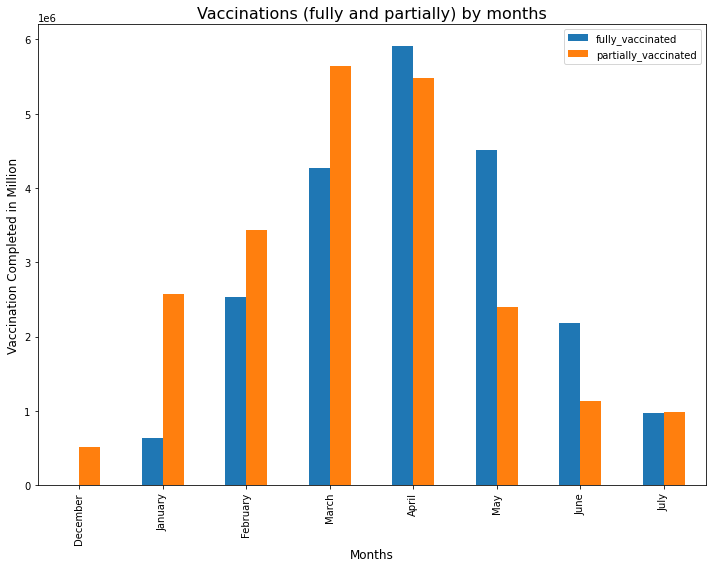

In [4]:
# Generating a bar plot showing the total number of completed vaccination by months
ca_vaccinated_completed = pd.DataFrame(ca_vaccinated, columns=['month','fully_vaccinated', 'partially_vaccinated'])
ca_vaccinated_completed_montly = ca_vaccinated_completed.groupby(ca_vaccinated_completed['month']).sum()

bar_plot = ca_vaccinated_completed_montly.plot.bar(figsize=(10,8))

plt.xlabel("Months",fontsize = 12)
plt.ylabel("Vaccination Completed in Million",fontsize = 12)
plt.title("Vaccinations (fully and partially) by months",fontsize = 16)

plt.tight_layout()

plt.savefig("./CA_vaccinations_by _months.png")
plt.show()

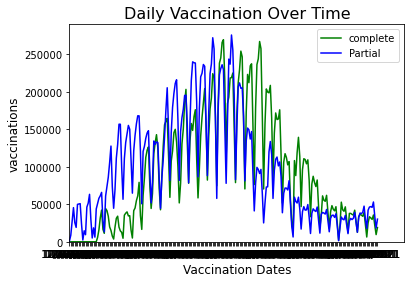

In [5]:
import matplotlib.pyplot as plt
import numpy as np

dates = ca_vaccinated['administered_date']
complete = ca_vaccinated['fully_vaccinated']
partial = ca_vaccinated['partially_vaccinated']

# Plot the charts and apply some styling

complete, = plt.plot(dates, complete, color="g", label="complete")
partial, = plt.plot(dates, partial, color="b", label="Partial")

# Add labels to X and Y axes :: Add title
plt.title("Daily Vaccination Over Time", fontsize = 16)
plt.xlabel("Vaccination Dates", fontsize = 12)
plt.ylabel("vaccinations", fontsize = 12)

# Set the limits for the X and Y axes
plt.xlim(0,250)
plt.ylim(0,290000)

# Create a legend for the chart
plt.legend(handles=[complete, partial], loc="best")
plt.show()

<AxesSubplot:>

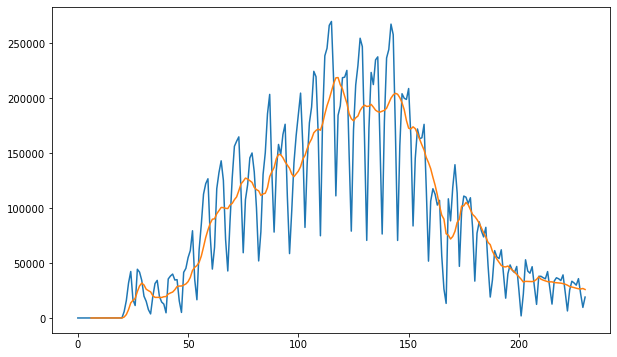

In [6]:
# Calculating 7 days moving average of complete vaccination

complete = ca_vaccinated['fully_vaccinated']
complete.plot(figsize=(10,6))
complete.rolling(window =7).mean().plot()


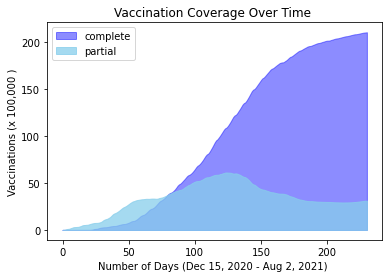

In [7]:
# Cumulative_vaccin_data for plotting vaccination coverage over time

dates = cumulative_vaccin_data['administered_date']
complete = cumulative_vaccin_data['cumulative_fully_vaccinated']/100000
partial = cumulative_vaccin_data['total_partially_vaccinated']/100000

# Plot the charts and apply some styling
plt.fill_between(np.arange(231), complete, color="blue", alpha=0.45, label='complete')
plt.fill_between(np.arange(231), partial, color="skyblue", alpha=0.75, label='partial')

plt.title("Vaccination Coverage Over Time ")
plt.xlabel("Number of Days (Dec 15, 2020 - Aug 2, 2021) ")
plt.ylabel("Vaccinations (x 100,000 )")

plt.legend(loc="upper left")
plt.show()

In [8]:
# Selecting only the residence county as reported in the data (elemination method is used)
ca_vaccin_data = csv_data.query('county !="All CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="All CA and Non-CA Counties"')
ca_vaccin_data = ca_vaccin_data.query('county !="Outside California"')
ca_vaccin_data = ca_vaccin_data.query('county !="Unknown"')

# getting new dataframe for total vaccination (fully and partially vaccinated) by counties

county_vac_data = ca_vaccin_data.groupby(ca_vaccin_data['county']).sum()

county_vac_data= pd.DataFrame(county_vac_data, columns =['partially_vaccinated', 'fully_vaccinated']).sort_values(by = \
                                                        'fully_vaccinated', ascending = False) 
# county_vac_data


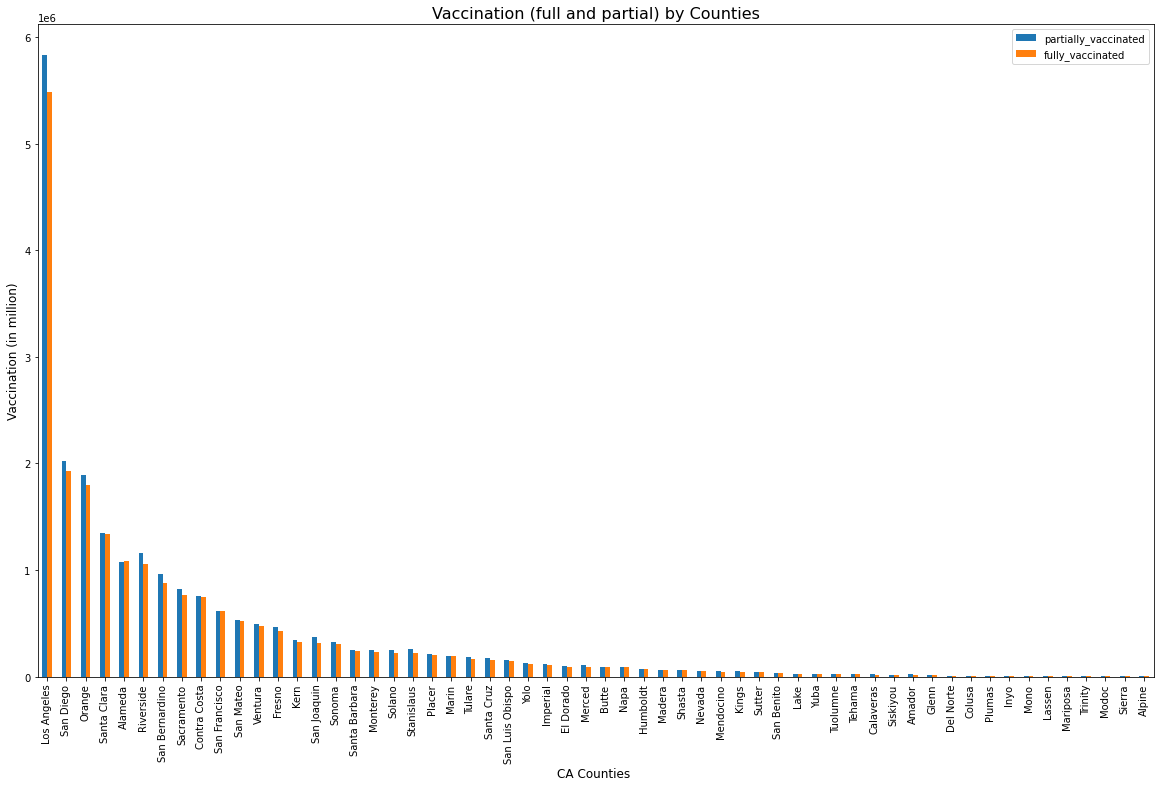

In [9]:
county_vac_data.plot(y = ['partially_vaccinated', 'fully_vaccinated'], kind='bar', figsize=(20,12))  #.bar(figsize=(16,9), color='g', alpha = 0.75)

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Vaccination (full and partial) by Counties",fontsize = 16)
plt.show()


In [25]:
# Reading the data file for population by county
pop_data = pd.read_csv("./CA_county_pop.csv")   # Source: https://www.california-demographics.com/counties_by_population
pop_data = pd.DataFrame(pop_data)

''' In order to merge with the vaccination data, the population data was cleaned with their county names by removing the 
 word "County" from their names and merged to get a new datafile ''' 

county = []
county_name = pop_data['County']
for i in county_name:
        size = len(i)
        mod_name = i[:size-7]
        county.append(mod_name)

pop_data['county'] = county
county_pop_data = pop_data[['county', 'Population']]
pop = pop_data['Population']

county_pop_vac_data = pd.merge(county_pop_data, county_vac_data, on = 'county', how = 'left')

county_pop_vac_data.to_csv("./CA_county_population_and_vaccination_data.csv", index=False)
# print(county)

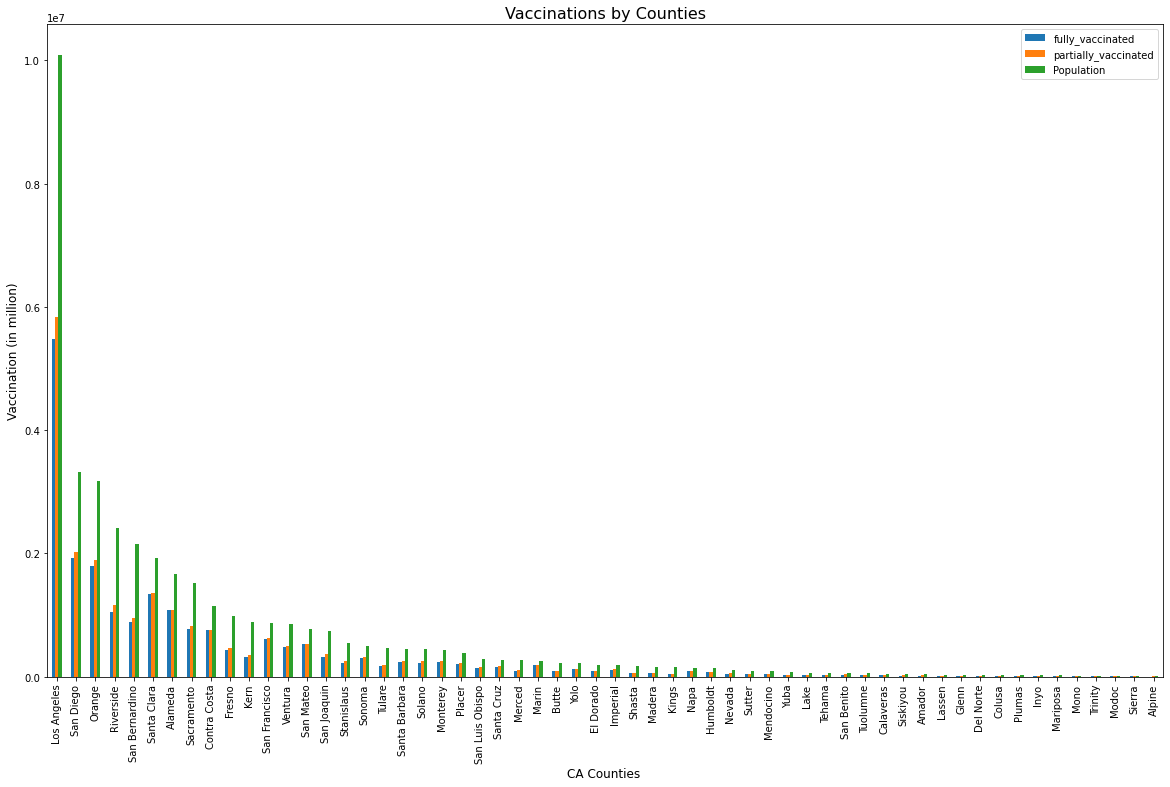

In [26]:
county_pop_vac_data = pd.read_csv("./CA_county_population_and_vaccination_data.csv", encoding = 'utf8')
county_pop_vac_data['Population'] = county_pop_vac_data['Population'].str.replace(',', '').astype(float)

county_pop_vac_data['Population']


county_pop_vac_data.plot(x="county", y = ['fully_vaccinated' ,'partially_vaccinated', 'Population'], kind="bar", figsize=(20,12))

plt.xlabel("CA Counties ",fontsize = 12)
plt.ylabel("Vaccination (in million)",fontsize = 12)
plt.title("Vaccinations by Counties",fontsize = 16)
plt.show()




In [27]:
'''Since the chart based on the actual counts of population, and vaccinations, some of the highly populated counties are not
comparable to the low populated counties. Percentage of the vaccinations on total population is calculated and ploted.''' 

county_pop_vac_data['Population'] = county_pop_vac_data['Population'].astype(float)
county_pop_vac_data['fully_vaccinated'] = county_pop_vac_data['fully_vaccinated'].astype(float) 
county_pop_vac_data['partially_vaccinated'] = county_pop_vac_data['partially_vaccinated'].astype(float)

county_pop_vac_data['full_percent'] = (county_pop_vac_data['fully_vaccinated'] / county_pop_vac_data['Population']) * 100
county_pop_vac_data['partial_percent'] = (county_pop_vac_data['partially_vaccinated'] / county_pop_vac_data['Population']) * 100

# county_pop_vac_data['full_percent']
# county_pop_vac_data['partial_percent']


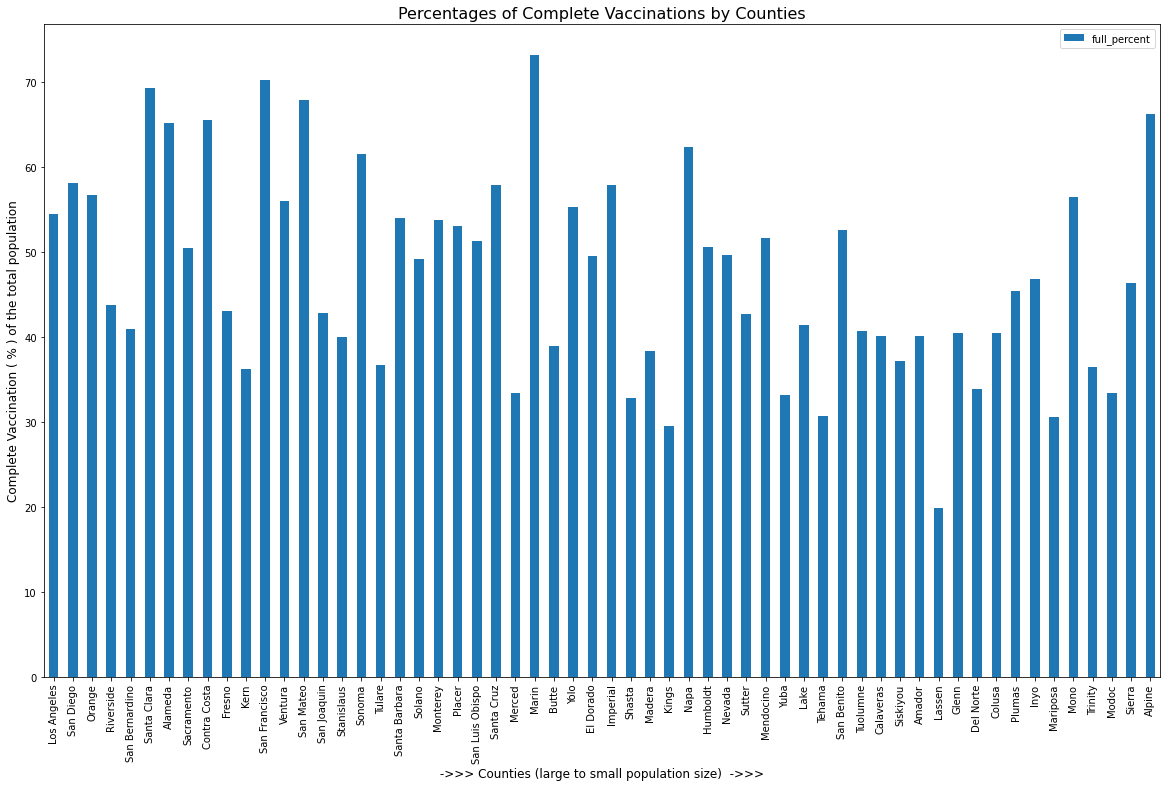

In [28]:
county_pop_vac_data.plot(x="county", y = ['full_percent'], kind="bar", figsize=(20,12))

plt.xlabel(" ->>> Counties (large to small population size)  ->>> ",fontsize = 12)
plt.ylabel("Complete Vaccination ( % ) of the total population",fontsize = 12)
plt.title("Percentages of Complete Vaccinations by Counties",fontsize = 16)
plt.show()


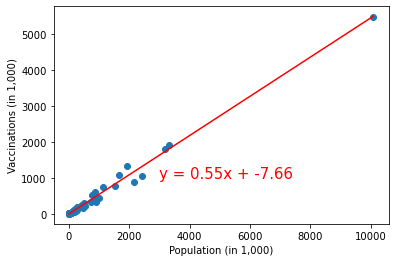

In [29]:
# Perform a linear regression on population versus complete vaccination
x_value = county_pop_vac_data['Population']/1000
y_value = county_pop_vac_data['fully_vaccinated']/1000
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_value = x_value * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_value,y_value)
plt.plot(x_value,regress_value,"r-")
plt.annotate(line_eq,(3000,1000),fontsize=15,color="red")
plt.xlabel('Population (in 1,000)')
plt.ylabel('Vaccinations (in 1,000)')
plt.show()



In [53]:
# Gettign geo location of California Counties
us_county_geo = pd.read_csv("./uscounties_geolocation.csv")   # Source: https://simplemaps.com/data/us-counties (updated 02/24/2021)
ca_county_geo = us_county_geo.query('state_id == "CA"')
ca_county_geo = pd.DataFrame(ca_county_geo, columns = ['county', 'lat', 'lng'])

# Merging vaccination data with the geolocation data by counties
county_pop_vac_geo = pd.merge(county_pop_vac_data, ca_county_geo, on = 'county', how = 'left')
county_pop_vac_geo.head()



,county,Population,partially_vaccinated,fully_vaccinated,full_percent,partial_percent,lat,lng
0,Los Angeles,10081570.0,5828030.0,5484678.0,54.403015,57.808754,34.3207,-118.2248
1,San Diego,3316073.0,2018518.0,1927095.0,58.113769,60.870735,33.0341,-116.7353
2,Orange,3168044.0,1886156.0,1796692.0,56.712975,59.536926,33.7030,-117.7611
3,Riverside,2411439.0,1156004.0,1054074.0,43.711410,47.938347,33.7437,-115.9938
4,San Bernardino,2149031.0,957518.0,878368.0,40.872747,44.555802,34.8414,-116.1784


In [62]:
# Creating map for counties with the vaccination coverages

from api_keys import g_key

gmaps.configure(api_key=g_key)


# Store latitude and longitude in locations

locations = county_pop_vac_geo[["lat", "lng"]]

vaccination_coverage = county_pop_vac_geo['fully_vaccinated']


# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights = vaccination_coverage, dissipating=False,\
                                 max_intensity= 5, point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure

fig

Figure(layout=FigureLayout(height='420px'))